# Assign land cover to FPA FOD wildfires
- Use MODIS land cover data for the best guess of land cover type burned by a given FPA-FOD wildfire. 
- Assume spherical burn scar around FPA FOD fire lat lon location. Use that scar to estimate the types of land cover burned by a fire. 
- The land cover data are 0.5 x 0.5 km, so many of the fires in FPA FOD will essentially have point estimate land cover types given the size of the grid. 


Consider impact of going from a burn area estimate on a slope to a flat world for the modis burn area. This may require using overlap only for assigning proportions of the assigned burn area value.  

In [1]:
area_of_modis_cell = (0.5*1000.)**2
print str(area_of_modis_cell) + " m2: area of 0.5 x 0.5 degree MODIS grid cell at equator"

m2_per_acre = 4046.86 # m2/acres
acres_per_cell = area_of_modis_cell / m2_per_acre

print str(acres_per_cell) + ": acres per modis land cover grid cell"

250000.0 m2: area of 0.5 x 0.5 degree MODIS grid cell at equator
61.7762907538: acres per modis land cover grid cell


| Value        | Label          |
| -------------|:-------------|
|0 | Water|
|1|Evergreen Needleleaf forest|
|2|Evergreen Broadleaf forest|
|3|Deciduous Needleleaf forest|
|4|Deciduous Broadleaf forest|
|5|Mixed forest|
|6|Closed shrublands|
|7|Open shrublands|
|8|Woody savannas|
|9|Savannas|
|10|Grasslands|
|11|Permanent wetlands|
|12|Croplands|
|13|Urban and built-up|
|14|Cropland/Natural vegetation mosaic|
|15|Snow and ice|
|16|Barren or sparsely vegetated|

This means that the 0.5 km modis land cover can resolve sub wildfire burn scar land cover types, i.e. it is and should be possible to estimate the different land covers that are consumed by large wildfires. 

### Get the MODIS land cover data loaded into the workspace

In [30]:
import gdal
import os
import numpy as np
from matplotlib import pylab as plt
# http://geopandas.org/set_operations.html
from shapely.geometry import Polygon, Point
import geopandas
import pandas as pd

%matplotlib inline

dataDir = os.path.join("..", "..", "metSpreadData", "GIS")
f = os.path.join(dataDir, "LCType.tif")
gtif = gdal.Open( f )
LC_data = np.array(gtif.GetRasterBand(1).ReadAsArray())

print "Shape of the LC data:"
print LC_data.shape

# Get the coordinates 
width  = gtif.RasterXSize
height = gtif.RasterYSize
gt     = gtif.GetGeoTransform()

print width
print height
print "gtiff.GetGeoTransform() returned attributes"
print gt

#print "working on getting unique values in large 2D array...."
#print "Unique land cover values array: " + str(np.unique(LC_data))


Shape of the LC data:
(43200, 86400)
86400
43200
gtiff.GetGeoTransform() returned attributes
(-179.9999999979966, 0.004166666666666719, 0.0, 89.9999999919177, 0.0, -0.004166666666666719)


Get the coordinates of these pixels. Make sure that the coordinate structure (lat lon) arrays represent pixel centers. 

In [2]:
# FIGURE OUT HOW TO DEFINE LAT LON ARRAYS FOR THESE DATA SUCH THAT THOSE COORDS
# REPRESENT THE CENTER OF PIXELS FROM THE GEOTIFF. THEN WE WILL KNOW EXACTLY 
# HOW TO USE THESE DATA. 

minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

print "Printing the coordinate limits as defined here:"
print "minx " + str(minx)
print "maxx " + str(maxx)
print "miny " + str(miny)
print "maxy " + str(maxy)

# Logically speaking, the data should span the length of the min and max coord values
# by the number of dim size. 
# TODO: Read the documentation to understand if these coords represent grid centers or 
# TODO: corners. 
LC_x = np.linspace(minx, maxx, LC_data.shape[1])
LC_y = np.linspace(maxy, miny, LC_data.shape[0])

Printing the coordinate limits as defined here:
minx -179.999999998
maxx 180.000000002
miny -90.0000000081
maxy 89.9999999919


In [6]:
print LC_x[0] 
print LC_x[-1] 
print LC_y[0]
print LC_y[-1]

-179.9999999979966
180.00000000200788
89.9999999919177
-90.00000000808454


## Make up fire location and test functionality of overlap methods below
#### Extensive testing still required
- Limit of very small fire
- Limit of very large fire (Implement geographic reference system)
-- http://geopandas.org/data_structures.html

----------------------------------------
Grid spacing in x 0.004166714892562595
Grid spacing in y 0.004166763119542338
----------------------------------------
Fire location and area:
-122.0
47.0
4046860000.0
fire_rad_deg: 1.0


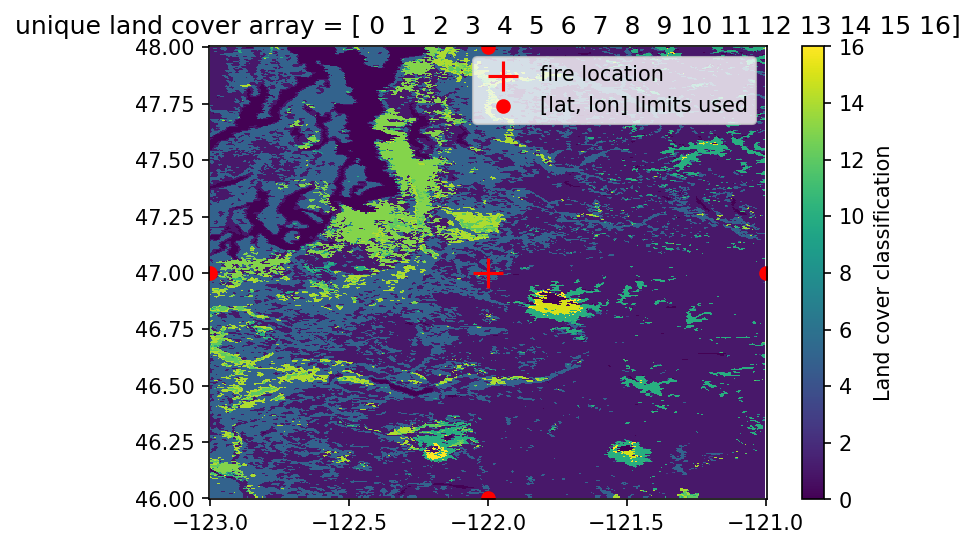

The raw subset array values
[[ 1  1  1 ... 10 10  8]
 [ 1  1  1 ... 10 14 14]
 [ 1  1  1 ... 10  5  5]
 ...
 [ 5  5  5 ...  1  1  1]
 [ 5  5  5 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]]
(480, 480)


In [37]:
# In order to subset the land cover grid around a fire's location, need to 
# know the width of the grid in deg units. Use max observed in the data, as
# it is ok to make a slightly larger than needed area to check fire overlap.
LC_grid_dx = np.max(np.diff(LC_x))
LC_grid_dy = np.max(np.abs(np.diff(LC_y)))

print "----------------------------------------"
print "Grid spacing in x " + str(LC_grid_dx)
print "Grid spacing in y " + str(LC_grid_dy)

# hypothetical wildfire with size specified in acres. These will come from FPA FOD.
# #rainier_summit = [-121.7586, 46.85449]
fire_size_acres = 1000000.
fire_lon = -122.#-122.341072    #-119.176894  
fire_lat = 47. #47.599264      # 46.487794 

# Need to get from acres to SI units so we can think about what this
# size fire means in terms of a lat lon grid
m2_per_acre = 4046.86
fire_area_m2 = fire_size_acres * m2_per_acre

print "----------------------------------------"
print "Fire location and area:"
print fire_lon
print fire_lat
print fire_area_m2

# Assuming the fire area is a circle, calculate radius from area
# NOTE: Area needs to be in m**2
fire_rad_m = np.sqrt(fire_area_m2/np.pi)

# Subset the LC grid needed to encompas this circle. Create spatial extents
# using local meters per degree values in the x and y directions. 
# NOTE: The coords of LC_grid units are degrees lon and lat. 
m_per_deg_lat = (111.*1000.) # ~111 km per deg and 1000 meter per km
m_per_deg_lon = (111.*1000.) * np.cos(fire_lat * np.pi/180.) # 0 at pole, 90 deg N. 

extend_dy_deg = fire_rad_m / m_per_deg_lat # degrees lat
extend_dx_deg = fire_rad_m / m_per_deg_lon # degrees lon 

# Fire radius needs to be expressed in terms of degrees for polygon creation
fire_rad_deg = 1. #fire_rad_m / m_per_deg_lat # np.mean([m_per_deg_lat, m_per_deg_lon])
print "fire_rad_deg: " + str(fire_rad_deg)

# Establish LC_grid extent where overlap calculations are needed
# Add one LC_grid box width to make sure the circle is covered. 
# NOTE: dx needs more deg grid boxes to cover same on the ground distance as 
# NOTE: dy. So applying extent_dx_deg to both directions to get extra
minLat = fire_lat - fire_rad_deg#(extend_dx_deg + LC_grid_dy) # (extend_dy_deg + LC_grid_dy)
maxLat = fire_lat + fire_rad_deg#(extend_dx_deg + LC_grid_dy) # (extend_dy_deg + LC_grid_dy)
minLon = fire_lon - fire_rad_deg#(extend_dx_deg + LC_grid_dx)
maxLon = fire_lon + fire_rad_deg#(extend_dx_deg + LC_grid_dx)

# Mask these extends on the LC coordinates and grid
lonIndex = np.where( ( (LC_x >= minLon) & (LC_x <= maxLon)) )[0]
latIndex = np.where( ( (LC_y >= minLat) & (LC_y <= maxLat) ) )[0]
LC_x_subset = LC_x[lonIndex]
LC_y_subset = LC_y[latIndex]
LC_subset   = LC_data[np.ix_(latIndex, lonIndex)]

# Get a local dx dy for this subset of grid boxes
LC_subset_dx = np.max(np.diff(LC_x_subset))
LC_subset_dy = np.max(np.abs(np.diff(LC_y_subset)))

# Make grid subset into an shapely polygon 
plt.figure(dpi=150)
plt.pcolor(LC_x_subset, LC_y_subset, LC_subset)
plt.xlim([minLon-LC_grid_dx, maxLon+LC_grid_dx])
plt.ylim([minLat-LC_grid_dy, maxLat+LC_grid_dy])
plt.colorbar(label="Land cover classification")
plt.title("unique land cover array = " + str(np.unique(LC_subset)) )
plt.scatter(fire_lon, fire_lat, color="red", marker="+", label="fire location", s=200)
# Add limits used to subset LC grid 
plt.scatter(fire_lon, maxLat, color="red")
plt.scatter(fire_lon, minLat, color="red")
plt.scatter(minLon, fire_lat, color="red")
plt.scatter(maxLon, fire_lat, color="red", label="[lat, lon] limits used")
#for i in range(len(LC_x_subset)):
#    for j in range(len(LC_y_subset)):
#        plt.scatter(LC_x_subset[i], LC_y_subset[j], color="blue")
plt.legend(loc=0)
plt.show()

print "The raw subset array values"
print LC_subset
print LC_subset.shape

### Develop funtion to determine overlap
on plotting shapes: https://gis.stackexchange.com/questions/197945/geopandas-polygon-to-matplotlib-patches-polygon-conversion

on overlapping shapes: https://stackoverflow.com/questions/14697442/faster-way-of-polygon-intersection-with-shapely/14804366#14804366

In [ ]:
# Make fire a circle shapely polygon object 
fire_poly = Point(fire_lon, fire_lat).buffer(fire_rad_deg)

print "---------------------------------------------------"
print "Initial Fire Circle Area: " + str(fire_poly.area)
print "---------------------------------------------------"

# NOTE: The definition of the polygon corners depends on whether the LC_grid_coords
# NOTE: represent grid corners or grid centers. 
# TODO: Retain land cover information here. 
ncolumn = len(LC_x_subset)
nrow = len(LC_y_subset)
print "ncolumn: " + str(ncolumn)
print "nrow: " + str(nrow)

# NOTE: This will break near edges of LC_subset. 
count = 0
LC_grid_polygon_list = [None] * (ncolumn * nrow)
LC_cover = [None] * (ncolumn * nrow)
print "length of LC_cover list: " + str(len(LC_cover))
for i in range(ncolumn):
    for j in range(nrow):
        
        # Get land cover for this grid box
        LC_cover[count] = LC_subset[j, i]
        
        # where coords are top left of pixels. 
        x0 = LC_x_subset[i] 
        x1 = LC_x_subset[i] + LC_subset_dx 
        y0 = LC_y_subset[j]
        y1 = LC_y_subset[j] - LC_subset_dy 
        LC_grid_polygon_list[count]  = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
        count = count + 1 # Advance the count of created polygons

print "For loop complete"
        
# Create GeoSeries of local grid and fire
grid_polys = geopandas.GeoSeries(LC_grid_polygon_list)
fire_polys = geopandas.GeoSeries(fire_poly)

# Setup geographic coordinate system for fire and grid boxes to live on.
crs_assign = {'init':'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'}
grid_polys.crs = crs_assign
fire_polys.crs = crs_assign

# Create GeoDataFrame, which have desirable properties and methods
grid_polys_df = geopandas.GeoDataFrame({'geometry': grid_polys, 'grid_LC_val':LC_cover})
fire_polys_df = geopandas.GeoDataFrame({'geometry': fire_polys, 'Fire':"FireName"})

print "GeoDataFrames created"

# TODO: why is there so much extra grid boxes surrounding the fire circle? 
# Show the grid and fire
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
grid_polys_df.plot(ax=ax, color='blue' ,alpha=0.5, edgecolor='black');
fire_polys_df.plot(ax=ax, color='red', alpha=0.5, edgecolor='black');
plt.scatter(fire_lon, fire_lat, color="black",marker="+", label="fire location", s=200)
plt.title(str(fire_area_m2) +" m$^{2}$ Fire perimeter and grid")
plt.legend()
plt.show()

---------------------------------------------------
Initial Fire Circle Area: 3.13654849055
---------------------------------------------------
ncolumn: 480
nrow: 480
length of LC_cover list: 230400
For loop complete
GeoDataFrames created


99.99999999999964


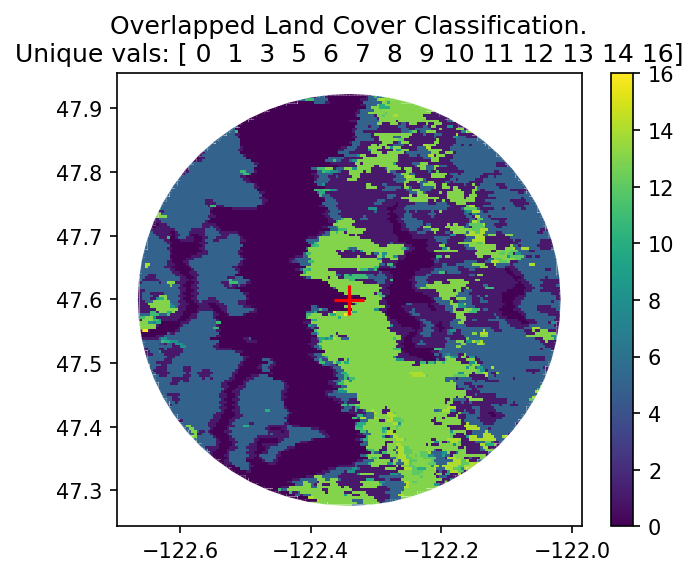

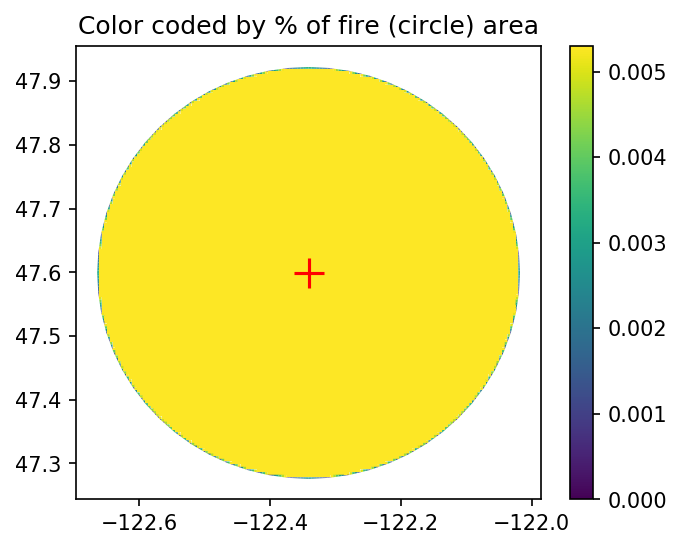

Max percent of circle area for a single gridcell: 0.005294418169689576
Min percent of circle area for a single gridcell: 3.079186876406284e-26
Sum of all percent overlap values: 99.99999999999964


,grid_LC_val,Fire,geometry,overlap_area,percent_of_fire_area
0,5,FireName,"POLYGON ((-122.507667910819 47.6031852508352, ...",9.028376e-17,9.028376e-15
1,5,FireName,"POLYGON ((-122.5035011959264 47.6031852508352,...",5.294418e-05,5.294418e-03
2,0,FireName,"POLYGON ((-122.4160001831832 47.6031852508352,...",9.028376e-17,9.028376e-15
3,0,FireName,"POLYGON ((-122.4118334682907 47.6031852508352,...",5.294418e-05,5.294418e-03
4,1,FireName,"POLYGON ((-122.5826687788846 47.6031852508352,...",9.028376e-17,9.028376e-15
5,0,FireName,"POLYGON ((-122.578502063992 47.6031852508352, ...",5.294418e-05,5.294418e-03
6,1,FireName,"POLYGON ((-122.578502063992 47.6031852508352, ...",3.079187e-28,3.079187e-26
7,0,FireName,"POLYGON ((-122.578502063992 47.6031852508352, ...",1.805696e-16,1.805696e-14
8,0,FireName,"POLYGON ((-122.0993298513507 47.6031852508352,...",9.028376e-17,9.028376e-15
9,0,FireName,"POLYGON ((-122.0951631364581 47.6031852508352,...",5.294418e-05,5.294418e-03


In [34]:
# returns only the geometries that are contained by both GeoDataFrames
res_intersection = geopandas.overlay(grid_polys_df, fire_polys_df, how='intersection')

# Add the overlapping area to this intersection dataframe 
res_intersection['overlap_area'] = pd.Series(res_intersection.area/fire_poly.area, 
                                             index=res_intersection.index)

# Append Percent Overlap information to the intersection DataFrame 
res_intersection['percent_of_fire_area'] = pd.Series(res_intersection.area/fire_poly.area*100., 
                                                     index=res_intersection.index)

print np.sum(res_intersection['percent_of_fire_area'])

# TODO: Estimate area error. What area is given by the polygon circle? How far off
# TODO: from original? 
#(fire_poly.area * m_per_deg * m_per_deg ) - fire_area


# TODO: WHY IS THE GRID ROTATED?
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
res_intersection.plot(ax=ax, column='grid_LC_val', legend=True) # edgecolor='black'
plt.scatter(fire_lon, fire_lat, color="red",marker="+", label="fire location", s=200)
plt.title("Overlapped Land Cover Classification.\nUnique vals: " 
          + str(np.unique(res_intersection["grid_LC_val"])))
plt.show()

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
res_intersection.plot(ax=ax, column='percent_of_fire_area', legend=True) # edgecolor='black',
plt.scatter(fire_lon, fire_lat, color="red", marker="+", label="fire location", s=200)
plt.title("Color coded by % of fire (circle) area")
plt.show()

print "Max percent of circle area for a single gridcell: " + str(np.max(res_intersection['percent_of_fire_area']))
print "Min percent of circle area for a single gridcell: " + str(np.min(res_intersection['percent_of_fire_area']))
print "Sum of all percent overlap values: " + str(np.sum(res_intersection['percent_of_fire_area']))

# Look at the dataframe
res_intersection

# Present the differences from point estimates

In [ ]:
from shapely.ops import cascaded_union
from rtree import index
idx = index.Index()

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(grid_cells):
    # assuming cell is a shapely object
    idx.insert(pos, cell.bounds)

# Loop through each Shapely polygon
for poly in polygons:
    # Merge cells that have overlapping bounding boxes
    merged_cells = cascaded_union([grid_cells[pos] for pos in idx.intersection(poly.bounds)])
    # Now do actual intersection
    print poly.intersection(merged_cells).area